# ТЗ

## Проект для задачи Яндекс Акедемии "Анализ экологических проблем"

На заводе по производству полезного полимера ООО “Synthesising the future“ обратились за помощью в исследовании зависимостей вредных выбросов от производственных показателей. Требуется повести анализ данных и построить выводы о том, какой этап имеет высокий риск создать повышенное содержания вредного газа.

### Описание проекта

Вы являетесь отделом аналитиков, к которым опратилась производственная компания ООО “Synthesising the future“. Они хотя выяснить причины, почему появляются высокие значения выбросов, хотя у них заявлено экологичное производство. Вас просят провести анализ данных и произвести необходимые преобразования, чтобы получить качественные расчеты опасного газа и продукции.

Ниже описана структура процесса. Всего есть 4 этапа:
 - Этап 1 - Создание мономеров из сырья (stage_1)
 - Этап 2 - Формирование n-мерных цепочек (stage_2)
 - Этап 3 - Изготовление полимера (stage_3)
 - Этап 4 - Создание продукта (stage_4)

Есть два типа данных:
 - input - входные параметры на этап. Обычно то, что добавляется, чтобы повлиять на процесс
 - output - выходные параметры. Это показатели датчиков и значение элементов на выходе

Данные – файл «analysing_environmental_issues.csv»

### Описание столбцов

- 'DateTime' - время измерения. Частота измерений - каждый час.
- 'stage_1_output_konv_avd' - процент конверсии сырья в мономер. Простыми словами, какая доля стала на входе превратилась в мономер.
- 'stage_2_input_water_sum' - количество подаваемой суммарной воды в агрегат, в м3.
- 'stage_2_output_bottom_pressure' - давление низа (bottom) в агрегате, в Па
- 'stage_2_output_bottom_temp' - температура низа в агрегате, в градусах Цельсия
- 'stage_2_output_bottom_temp_hum_steam' - температура насыщенного пара низа в агрегате, в градусах Цельсия
- 'stage_2_output_bottom_vacuum' - вакуум низа в агрегате, в Па
- 'stage_2_output_top_pressure' - давление верха (top) в агрегате, в Па
- 'stage_2_output_top_pressure_at_end' - давление верха в агрегате на выходе, в Па
- 'stage_2_output_top_temp' - температура низа в агрегате, в градусах Цельсия
- 'stage_2_output_top_vacuum' - вакуум низа в агрегате, в Па
- 'stage_3_input_pressure' - подаваемое давление в агрегат, в Па
- 'stage_3_input_soft_water' - подаваемая смягченная вода, в м3
- 'stage_3_input_steam'- подаваемый пар, в м3
- 'stage_3_output_temp_hum_steam' - температура насыщенного пара, в градусах Цельсия
- 'stage_3_output_temp_top' - температура верха в агрегате, в градусах Цельсия
- 'stage_4_input_overheated_steam' - подача перегретого пара, в м3
- 'stage_4_input_polymer' - подача полимера, в м3
- 'stage_4_input_steam' - подача пара, в м3
- 'stage_4_input_water' - подача воды, в м3
- 'stage_4_output_danger_gas' - доля опасного газа на выходе агрегата, 1 = 100%, 0 = 0%. Это показатель замеряется вручную и имеет другую шкалу измерений. его не делают каждый час, а только тогда, когда требуется.
- 'stage_4_output_dry_residue_avg' - процент сухого остатка финального продукта
- 'stage_4_output_product' - готовый продукт технологического процесса, в кг
- 'work_shift' - номер смены, от 1 до 2

### Постановка задачи

- Провести исследовательский анализ данных (EDA)
- Создать расчеты
- Выполнить проверку гипотез
- Выполнить регрессионное моделирование
- Добавить дашборт по результатам работы

#### Исследование данных на качество

- \[X\]  Исследовать типы данных, привести данные к правильному типу, где это необходимо
- \[X\]  Проверить данные на выбросы и адекватность данных. Предположить причину возникновения выбросов и обработать такие значения.
- \[X\]  Указать на основе выбросов верхние и нижние границы. Указать каким признакам нужны границы, или часть границ и вовсе не нужны границы выбросов.
- \[X\]  Провести аналитический и графический анализ данных. Добавить границы значений. Сделать выводы.
- \[X\]  Проверить данные на пропуски и заполнить их при необходимости. Обосновать решение.

#### Проведение расчётов

- \[X\] Создать категорию опасности вредного газа от 1 до 3. Низкая опасность (1) показатель до 0.05, средняя(2) - от 0.05 до 0.16, высокая(3) - от 0.16
- \[X\] Создать сводную таблицу изменения параметров сгруппированную по дням без учета номера смены. Выведите суммарные показатели входных параметров. При однотипности парамтра проведите суммирования. Сделайте выводы по расходу ресурсов каждый день. Есть ли периоды, когда компания тратила больше ресурсов?
- \[X\] Создать сводную таблицу изменения категории опасности сгруппированную по месяцам. Выводите ту категориЮ. которая была чаще всего в месяца. Есть ли в течении года периоды, когда проищводство было самым опасным?
- \[X\] Для каждой категории вывести среднее значение каждого параметра (без учета номера смены). Есть ли заметные отличия типа категории?
- \[X\] Провести корреляционный анализ для поиска зависимостей. Дать выводы. Отдельно пояснить корреляции для столбцов 'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg' и 'stage_4_output_product'.

#### Проверка гипотез

- \[X\] Гипотеза 1. Если ли различия в доле опасного газа от смены?
- \[X\] Гипотеза 2. Какая из смен лучше управляет температурой верха на этапе 3? Считать, что высокая температура хуже.
- \[X\] Гипотеза 3. Конверсия мономера на 1 этапе влияет на количество подаваемой суммарной воды.
- \[X\] Гипотеза 4. Количество выходного продукта связано с долей опасного газа
- \[X\] Гипотезы 5-7. Дополнительно выдвинуть и проверить не менее 3 гипотез по влиянию разных факторов на любой из выходных параметров этапа 4.

#### Регрессионное моделирование

- \[X\] Провести моделирование показателя доля опасного газа. Выбор и аргументация факторов свободный. Оценить модель на метриках R2 и MAPE. Дать выводы, можно ли использовать модель вместо ручных замеров

#### Попросить создать дашборд

- \[X\] На основе результатов выполненных расчетов и исследований составить информативный дашборд: показать наиболее интересные найденные зависимости, результаты проверки гипотез, основные статистики/распределения предоставленных данных: то, что может быть интересно и полезно заказчику для развития его бизнеса.

#### Выводы

- \[X\] Оформите выводы и дашборд в презентацию для руководства компании (не более 10 слайдов).

При составлении помните про основной вопрос заказчика: “Какие факторы влияют на долю опасного газа? Какие параметры требуют особого внимания”

# Код

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, mannwhitneyu, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error

**Нужно поменять путь к файлу!!!**

In [110]:
FILENAME = '/content/analysing_environmental_issues.csv'
df = pd.read_csv(FILENAME)

## Исследование данных на качество

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DateTime                              4400 non-null   object 
 1   stage_1_output_konv_avd               4159 non-null   float64
 2   stage_2_input_water_sum               4177 non-null   float64
 3   stage_2_output_bottom_pressure        4180 non-null   float64
 4   stage_2_output_bottom_temp            4209 non-null   float64
 5   stage_2_output_bottom_temp_hum_steam  4223 non-null   float64
 6   stage_2_output_bottom_vacuum          4169 non-null   float64
 7   stage_2_output_top_pressure           4218 non-null   float64
 8   stage_2_output_top_pressure_at_end    4226 non-null   float64
 9   stage_2_output_top_temp               4196 non-null   float64
 10  stage_2_output_top_vacuum             4205 non-null   float64
 11  stage_3_input_pre

### Удаление пустых строк

Удаляем строки, в котрых нет никаких значений кроме даты (то есть часы, когда измерения не проводились).

In [112]:
nan_cols = ['stage_1_output_konv_avd', 'stage_2_input_water_sum',
       'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp',
       'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum',
       'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end',
       'stage_2_output_top_temp', 'stage_2_output_top_vacuum',
       'stage_3_input_pressure', 'stage_3_input_soft_water',
       'stage_3_input_steam', 'stage_3_output_temp_hum_steam',
       'stage_3_output_temp_top', 'stage_4_input_overheated_steam',
       'stage_4_input_polymer', 'stage_4_input_steam', 'stage_4_input_water',
       'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg',
       'stage_4_output_product', 'work_shift']
df.dropna(subset=nan_cols, how='all', inplace=True)

### Привидение к нужному типу

In [113]:
df['work_shift'] = df['work_shift'].astype('int')

### Создание колонок month и day

In [114]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['month'] = df['DateTime'].dt.strftime('%Y-%m')
df['day'] = df['DateTime'].dt.strftime('%Y-%m-%d')

In [115]:
df.head()

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift,month,day
0,2021-01-28 18:00:00,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,156.67,19.08,5.92,356.05,NaN,21.48,47.03,2,2021-01,2021-01-28
1,2021-01-28 19:00:00,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,156.76,19.15,5.94,357.69,NaN,21.48,45.05,2,2021-01,2021-01-28
2,2021-01-28 20:00:00,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,156.86,19.23,5.97,359.33,NaN,21.48,43.06,2,2021-01,2021-01-28
3,2021-01-28 21:00:00,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,156.41,19.36,5.97,339.99,0.16,21.48,46.01,2,2021-01,2021-01-28
4,2021-01-28 22:00:00,68.03,89.84,474.00,75.06,97.46,51.51,365.49,262.04,97.15,...,155.96,19.49,5.97,320.64,NaN,21.48,48.95,2,2021-01,2021-01-28


### Заполнение пропусков

In [116]:
df.isna().sum()

,0
DateTime,0
stage_1_output_konv_avd,81
stage_2_input_water_sum,63
stage_2_output_bottom_pressure,60
stage_2_output_bottom_temp,31
stage_2_output_bottom_temp_hum_steam,17
stage_2_output_bottom_vacuum,71
stage_2_output_top_pressure,22
stage_2_output_top_pressure_at_end,14
stage_2_output_top_temp,44


In [117]:
nan_cols = list(df.columns[df.isna().sum() > 0])
nan_cols.remove('stage_4_output_danger_gas')

In [118]:
for col in nan_cols:
  df[col] = df[col].interpolate(method='nearest')

## Расчёты

### Категория опасности газа

In [119]:
df['stage_4_output_danger_gas_cat'] = df['stage_4_output_danger_gas'].apply(lambda x: 1 if x < 0.05 else 2 if x <= 0.16 else 3)

In [120]:
df.head()

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift,month,day,stage_4_output_danger_gas_cat
0,2021-01-28 18:00:00,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,19.08,5.92,356.05,NaN,21.48,47.03,2,2021-01,2021-01-28,3
1,2021-01-28 19:00:00,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,19.15,5.94,357.69,NaN,21.48,45.05,2,2021-01,2021-01-28,3
2,2021-01-28 20:00:00,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,19.23,5.97,359.33,NaN,21.48,43.06,2,2021-01,2021-01-28,3
3,2021-01-28 21:00:00,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,19.36,5.97,339.99,0.16,21.48,46.01,2,2021-01,2021-01-28,2
4,2021-01-28 22:00:00,68.03,89.84,474.00,75.06,97.46,51.51,365.49,262.04,97.15,...,19.49,5.97,320.64,NaN,21.48,48.95,2,2021-01,2021-01-28,3


### Сводная таблица траты ресурсов по дням

In [121]:
input_params = [col for col in df.columns if 'input' in col]
output_params = [col for col in df.columns if 'output' in col]
new_df = df.groupby('day')[input_params].agg('sum')

In [122]:
def sum_water(row):
  return row['stage_2_input_water_sum'] + row['stage_3_input_soft_water'] + row['stage_4_input_water']

In [123]:
def sum_steam(row):
  return row['stage_3_input_steam'] + row['stage_4_input_overheated_steam'] + row['stage_4_input_steam']

In [124]:
new_df['input_water_sum'] = new_df.apply(sum_water, axis=1)
new_df['input_steam_sum'] = new_df.apply(sum_steam, axis=1)

In [125]:
def find_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1 * iqr
    upper_bound = q3 + 1 * iqr

    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

In [126]:
for col in new_df:
  print(find_outliers(new_df, col)[col])

day
2021-02-06    3103.94
2021-02-07    3104.14
2021-02-13    3108.51
2021-02-14    3202.86
2021-04-14    4050.39
2021-04-15    4469.87
2021-04-18    3777.05
2021-04-19    3451.90
Name: stage_2_input_water_sum, dtype: float64
Series([], Name: stage_3_input_pressure, dtype: float64)
day
2021-02-06    10790.96
2021-08-06    11351.97
2021-08-07    13375.47
2021-11-25    13073.06
2021-11-26    12366.27
2021-11-27    12471.01
2021-11-28    12528.38
2021-11-29    12227.16
2021-11-30    11367.87
2021-12-07    12670.98
2021-12-08    11958.68
2022-06-09    11228.88
2022-06-12    13106.47
2022-06-13    12076.93
2022-07-17    10830.04
2022-07-21    13142.80
2022-07-23    11049.59
Name: stage_3_input_soft_water, dtype: float64
day
2021-02-06    37991.77
2021-02-07    37326.20
2021-03-18    33633.42
2022-02-23    32047.00
2022-02-24    33638.12
2022-02-25    33259.79
2022-02-26    31933.65
2022-02-28    31678.81
Name: stage_3_input_steam, dtype: float64
Series([], Name: stage_4_input_overheated_ste

6-7 февраля 2021 заметно высокое потребление воды и пара.

### Сводная таблица категории опасности по месяцам

In [127]:
df.groupby('month')['stage_4_output_danger_gas_cat'].apply(lambda x: x.mode()[0])

,stage_4_output_danger_gas_cat
month,
2021-01,3
2021-02,3
2021-03,3
2021-04,3
2021-08,3
2021-09,3
2021-11,3
2021-12,3
2022-01,3


В основном категория опасности - 3 (высокая), в сентябре-ноябре 2022 производство было менее опасным (2 категория).

### Средние значения параметров по категориям опасности

In [128]:
df.groupby('stage_4_output_danger_gas_cat').mean(numeric_only=True)

,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,stage_2_output_top_vacuum,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
stage_4_output_danger_gas_cat,,,,,,,,,,,,,,,,,,,,,
1,65.830000,80.640000,383.996000,78.536000,101.944000,56.360000,450.904000,266.380000,93.890000,58.212000,...,109.586000,41.268000,153.314000,18.092000,4.612000,232.050000,0.036000,21.800000,43.484000,1.800000
2,69.043094,87.720791,396.106863,79.030446,98.170892,56.532460,455.714518,262.289525,94.356403,59.211165,...,109.453698,42.289899,153.342173,20.089957,5.269151,299.922475,0.124201,22.266331,44.072734,1.494964
3,69.541215,86.509124,405.641234,79.249328,98.533647,56.802028,449.077288,261.437698,94.673017,59.017537,...,110.105356,42.882119,153.468797,20.186432,5.429065,317.062862,0.189701,22.472853,46.797277,1.480226


Итак, на высокую категорию опасности влияют:

1 стадия:

*   большая доля конверсии сырья в мономер

2 стадия:

*   много воды, подаваемой в агрегат
*   высокое давление низа в агрегате
*   низкое давление верха в агрегате на выходе

3 стадия:

*   мало смягчённой воды
*   экстремально много подаваемого пара

4 стадия:

*   большое кол-во подаваемого полимера
*   большая подача пара
*   слишком много подаваемой воды
*   бОльшее кол-во готового продукта

<Axes: xlabel='stage_4_output_danger_gas_cat', ylabel='stage_3_input_steam'>

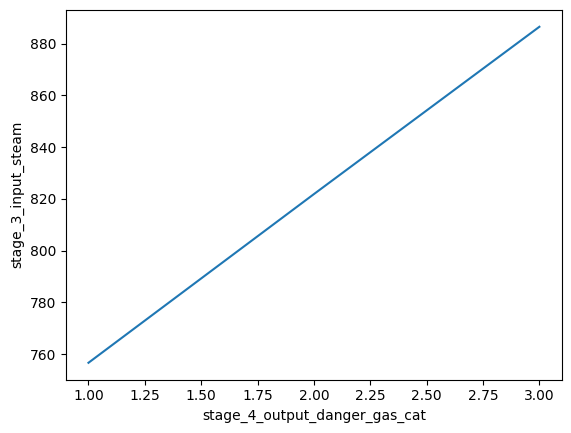

In [129]:
sns.lineplot(data=df.groupby('stage_4_output_danger_gas_cat')['stage_3_input_steam'].mean())

<Axes: xlabel='stage_4_output_danger_gas_cat', ylabel='stage_4_input_water'>

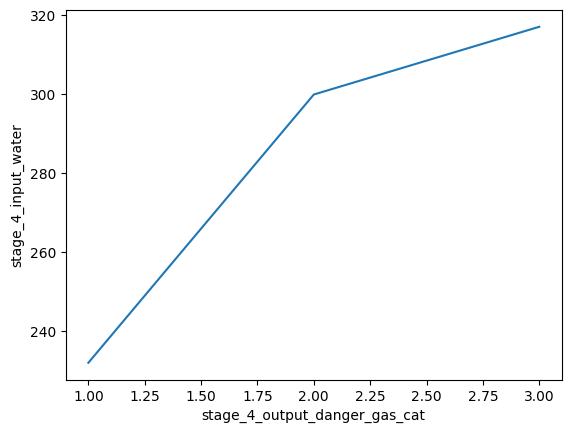

In [130]:
sns.lineplot(data=df.groupby('stage_4_output_danger_gas_cat')['stage_4_input_water'].mean())

### Корреляционный анализ

In [131]:
numeric_columns = df.select_dtypes(include=['number']).columns

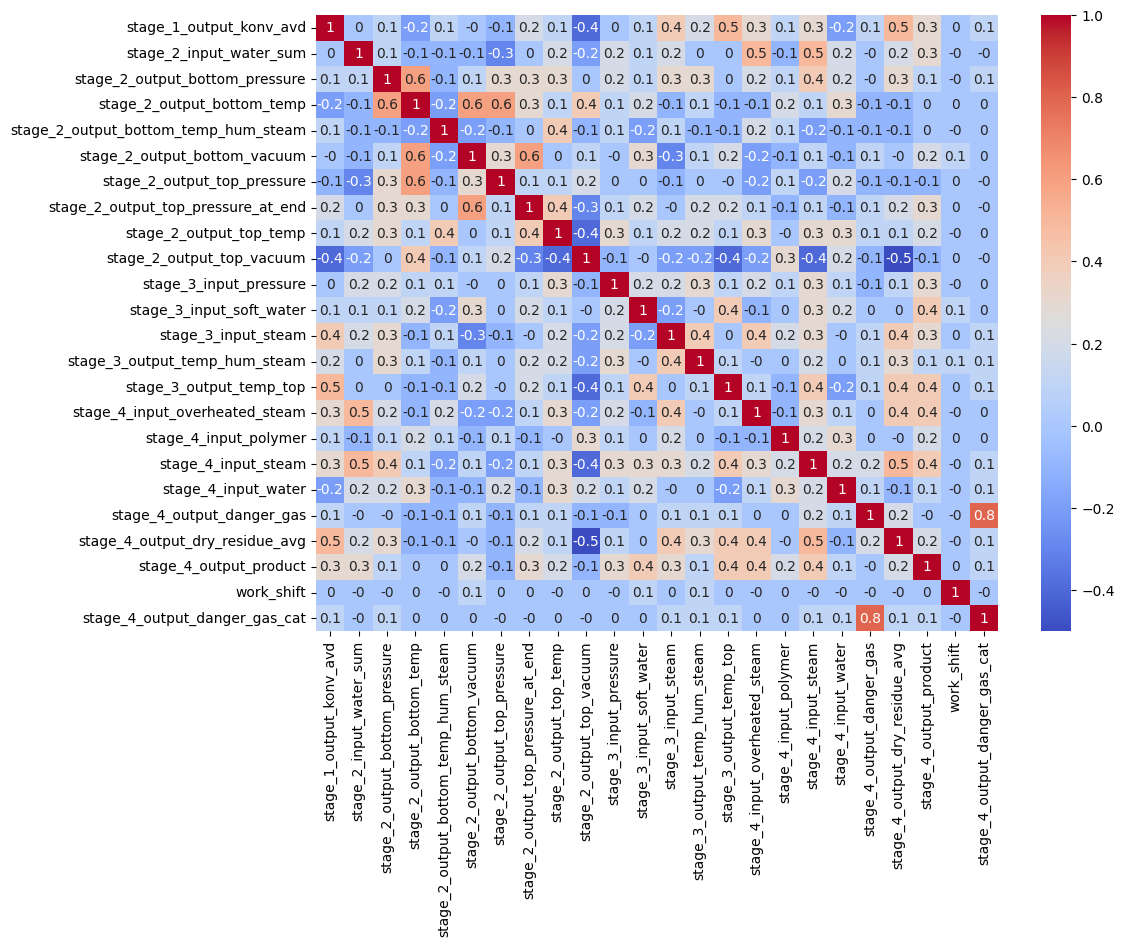

In [132]:
corr_matrix = df[numeric_columns].corr().round(1)
plt.figure(figsize=(11, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

На большой процент сухого остатка влияет:

*   большой процент конверсии сырья в мономер
*   мало вакуума верха на 2 стадии
*   много подаваемого пара на 3 стадии
*   высокая температура верха в агергате на 3 стадии
*   много перегретого пара на 4 стадии
*   много подаваемого пара на 4 стадии

На большую массу готового продукта влияют:

*   большая подача смягчённой воды
*   высокая температура верха в агергате на 3 стадии
*   много перегретого пара на 4 стадии
*   много подаваемого пара на 4 стадии

## Проверка гипотез

### 1

Используем только те данные, где нет пропусков в колонке `stage_4_output_danger_gas`.

In [133]:
df1 = df.dropna()

In [134]:
df1.isna().sum()

,0
DateTime,0
stage_1_output_konv_avd,0
stage_2_input_water_sum,0
stage_2_output_bottom_pressure,0
stage_2_output_bottom_temp,0
stage_2_output_bottom_temp_hum_steam,0
stage_2_output_bottom_vacuum,0
stage_2_output_top_pressure,0
stage_2_output_top_pressure_at_end,0
stage_2_output_top_temp,0


In [135]:
g1 = df1[df1['work_shift'] == 1]['stage_4_output_danger_gas']
g2 = df1[df1['work_shift'] == 2]['stage_4_output_danger_gas']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем метод Манна-Уитни.

In [136]:
mannwhitneyu(g1, g2, alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(110984.0), pvalue=np.float64(0.6313715279936567))

p-уровень равен 0.6, значит этих данных не достаточно, чтобы понять, есть ли различия в доле опасного газа в зависимости от смены.

### 2

In [137]:
g1 = df[df['work_shift'] == 1]['stage_3_output_temp_top']
g2 = df[df['work_shift'] == 2]['stage_3_output_temp_top']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем метод Манна-Уитни.

In [138]:
mannwhitneyu(g1, g2, alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(2236663.5), pvalue=np.float64(0.8419190698315876))

p-уровень равен 0.8, значит этих данных не достаточно, чтобы понять, какая из смен лучше управляет температурой верха на 3 этапе.

### 3

In [139]:
g1 = df['stage_1_output_konv_avd']
g2 = df['stage_2_input_water_sum']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем метод Манна-Уитни.

In [140]:
mannwhitneyu(g1, g2)

MannwhitneyuResult(statistic=np.float64(5552493.5), pvalue=np.float64(3.9902599175558374e-204))

p-уровень меньше 0.05, значит мы можем говорить, что конверсия мономера на 1 этапе влияет на количество подаваемой суммарной воды.

### 4

In [141]:
g1 = df1['stage_4_output_product']
g2 = df1['stage_4_output_danger_gas']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем метод Манна-Уитни.

In [142]:
mannwhitneyu(g1, g2)

MannwhitneyuResult(statistic=np.float64(872356.0), pvalue=np.float64(1.0402439135695203e-306))

p-уровень меньше 0.05, значит мы можем говорить, что количество выходного продукта связано с долей опасного газа.

### 5 - Большое кол-во подаваемого пара на 3 стадии влечёт бОльший процент сухого остатка

In [143]:
g1 = df['stage_4_output_dry_residue_avg']
g2 = df['stage_3_input_steam']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем Спирмен.

In [144]:
spearmanr(g1, g2)

SignificanceResult(statistic=np.float64(0.4719149819163528), pvalue=np.float64(3.690288841821099e-234))

Значение корреляции - 0.47, p-уровень меньше 0.05, значит зависимость есть, и этому значению можно доверять.

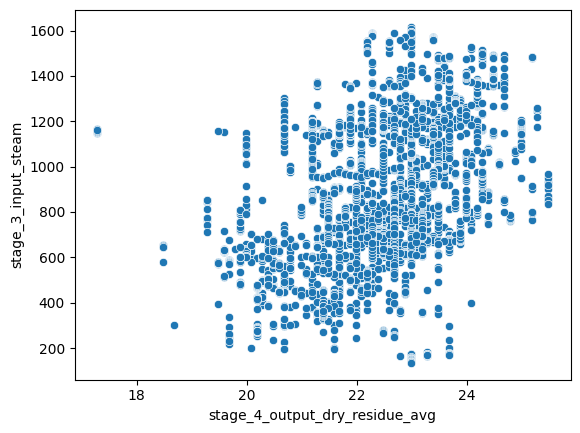

In [145]:
sns.scatterplot(data=df[['stage_4_output_dry_residue_avg', 'stage_3_input_steam']], x='stage_4_output_dry_residue_avg', y='stage_3_input_steam')
plt.show()

### 6 - Большой процент сухого остатка и большая масса готового продукта возможны ТОЛЬКО при достаточно высокой температуре верха в агрегате на 3 стадии


In [146]:
g1 = df['stage_4_output_dry_residue_avg']
g2 = df['stage_3_output_temp_top']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем Спирмен.

In [147]:
spearmanr(g1, g2)

SignificanceResult(statistic=np.float64(0.1957172464322126), pvalue=np.float64(7.08111885397671e-38))

In [148]:
g1 = df['stage_4_output_product']
g2 = df['stage_3_output_temp_top']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем Спирмен.

In [149]:
spearmanr(g1, g2)

SignificanceResult(statistic=np.float64(0.23493264386419765), pvalue=np.float64(2.933257197221507e-54))

В первом случае значение корреляции - 0.2, во втором - 0.23, p-уровень в обоих случаях меньше 0.05, значит небольшая зависимость есть, и этому значению можно доверять.

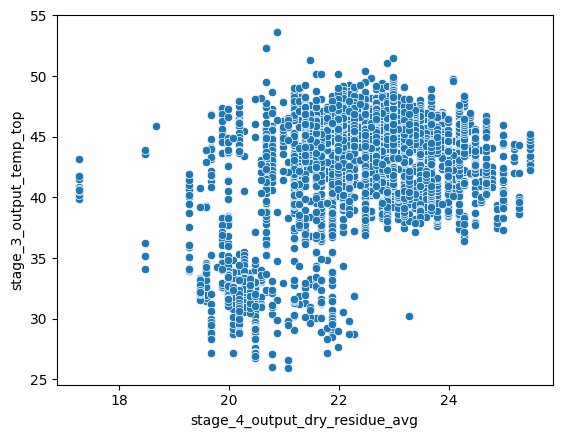

In [150]:
sns.scatterplot(data=df[['stage_4_output_dry_residue_avg', 'stage_3_output_temp_top']], x='stage_4_output_dry_residue_avg', y='stage_3_output_temp_top')
plt.show()

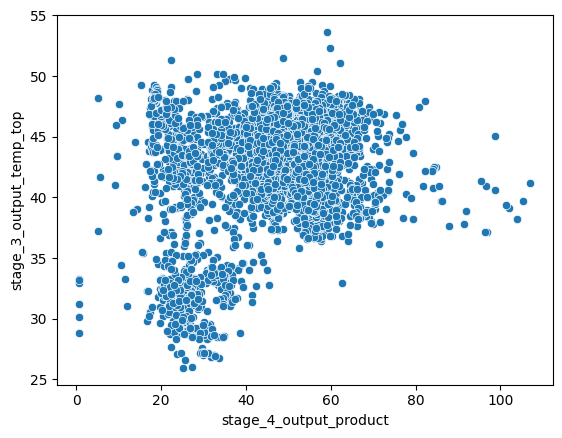

In [151]:
sns.scatterplot(data=df[['stage_4_output_product', 'stage_3_output_temp_top']], x='stage_4_output_product', y='stage_3_output_temp_top')
plt.show()

### 7 - Большое кол-во вакуума на 2 стадии НЕ даёт большой процент сухого остатка

In [152]:
g1 = df['stage_4_output_dry_residue_avg']
g2 = df['stage_2_output_top_vacuum']
print(shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05)

False


Распределение ненормалное, используем Спирмен.

In [153]:
spearmanr(g1, g2)

SignificanceResult(statistic=np.float64(-0.39393617087685645), pvalue=np.float64(1.9927251612070704e-157))

Значение корреляции - -0.4, p-уровень меньше 0.05, значит зависимость есть, и этому значению можно доверять.

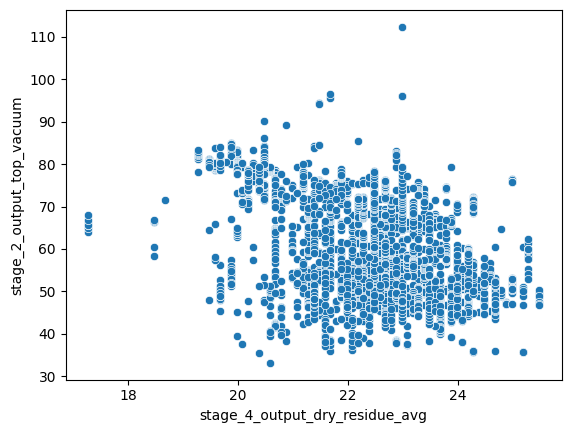

In [154]:
sns.scatterplot(data=df[['stage_4_output_dry_residue_avg', 'stage_2_output_top_vacuum']], x='stage_4_output_dry_residue_avg', y='stage_2_output_top_vacuum')
plt.show()

## Регрессионное моделирование

In [155]:
factors = df1[['stage_1_output_konv_avd', 'stage_2_output_bottom_temp',
              'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum',
              'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end',
              'stage_2_output_top_temp', 'stage_2_output_top_vacuum',
              'stage_3_input_pressure', 'stage_3_input_steam', 'stage_3_output_temp_hum_steam',
              'stage_3_output_temp_top', 'stage_4_input_steam', 'stage_4_input_water',
              'stage_4_output_dry_residue_avg']]

In [156]:
x_train, x_test, y_train, y_test = train_test_split(factors, df1['stage_4_output_danger_gas'], test_size=0.15, random_state=42)

In [157]:
lr = LinearRegression()
lr.fit(x_train, y_train)
prediction = lr.predict(x_test)

In [158]:
prediction

array([0.12500692, 0.15087394, 0.16754564, 0.14041651, 0.12344805,
       0.13953163, 0.11769374, 0.13958336, 0.14236654, 0.13994809,
       0.1518616 , 0.15249969, 0.16085852, 0.12638695, 0.13209589,
       0.13241279, 0.16955661, 0.13267158, 0.14545523, 0.15812794,
       0.12954975, 0.15268443, 0.13946136, 0.13662665, 0.13554571,
       0.15440333, 0.12121087, 0.13441256, 0.16478399, 0.13626421,
       0.1444667 , 0.14731971, 0.14517991, 0.12486847, 0.15735541,
       0.13498735, 0.12183664, 0.14314756, 0.12509746, 0.13710571,
       0.15131761, 0.14570053, 0.15322591, 0.15419866, 0.1477338 ,
       0.13515749, 0.12315613, 0.14492671, 0.15208775, 0.136892  ,
       0.12982061, 0.15183864, 0.12951914, 0.12443032, 0.14827136,
       0.13986142, 0.15230984, 0.15901864, 0.12832729, 0.16746243,
       0.15020824, 0.1204683 , 0.13847958, 0.13221653, 0.12116871,
       0.14810444, 0.14267739, 0.11961209, 0.12611154, 0.14303444,
       0.15141846, 0.15016656, 0.1322741 , 0.15653391, 0.13822

In [159]:
r2 = r2_score(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)

In [160]:
print(r2, mape * 100)

0.08960296803196499 25.052299397490334


Значения метрик достаточно маленькие, значит предсказание модели не очень качественное. Среди данных параметров не было обнаружено тех факторов, которые сильно влияют на долю опасного газа, поэтому с помощью модели нельзя с высокой точностью предсказать эти значения.